In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.cluster import KMeans
import pykalman as pk

In [2]:
# Load the GPS data from the .log file
data_gps1 = pd.read_csv('./Data/1/gps/gps_2023-04-20.log', sep=';')

# Data cleaning and formatting
data_gps1['Latitude'] = data_gps1['Latitude'].str.rstrip('N').astype(float)
data_gps1['Longitude'] = data_gps1['Longitude'].str.rstrip('E').astype(float)
data_gps1['Date'] = pd.to_datetime(data_gps1['Date'], format='%d/%m/%Y')
data_gps1['Time'] = pd.to_datetime(data_gps1['Time'], format='%H:%M:%S').dt.time

# Drop MagenticVariation column as it is not relevant to the problem
data_gps1.drop(columns=['MagneticVariation'], inplace=True)

# Filter rows where the date is '2023-04-20'
data_gps1 = data_gps1[data_gps1['Date'] == '2023-04-20']

print(data_gps1)


            Date      Time  Latitude  Longitude  Speed  TrackAngle
6938  2023-04-20  00:00:00   58.3098    15.1327   2.42      340.11
6939  2023-04-20  00:00:01   58.3098    15.1327   2.90      336.39
6940  2023-04-20  00:00:02   58.3098    15.1326   3.53      348.29
6941  2023-04-20  00:00:03   58.3099    15.1326   4.02      345.83
6942  2023-04-20  00:00:04   58.3099    15.1326   4.54      343.28
...          ...       ...       ...        ...    ...         ...
83740 2023-04-20  21:59:08   59.5635    17.8822   0.66      286.10
83741 2023-04-20  21:59:09   59.5635    17.8822   0.24      286.10
83742 2023-04-20  21:59:10   59.5635    17.8822   0.21      286.10
83743 2023-04-20  21:59:11   59.5635    17.8822   1.39      286.10
83744 2023-04-20  21:59:12   59.5635    17.8822   0.05      286.10

[76807 rows x 6 columns]


In [3]:
# Summary statistics
print("Summary Statistics:")
print(data_gps1.describe())

Summary Statistics:
                      Date      Latitude     Longitude         Speed  \
count                76807  76807.000000  76807.000000  76807.000000   
mean   2023-04-20 00:00:00     59.456417     17.416823      8.643521   
min    2023-04-20 00:00:00     56.903300     14.561400      0.000000   
25%    2023-04-20 00:00:00     59.402400     16.505200      0.260000   
50%    2023-04-20 00:00:00     59.563400     17.882000      0.470000   
75%    2023-04-20 00:00:00     59.563500     17.882100      1.000000   
max    2023-04-20 00:00:00     59.655000     17.927000     55.920000   
std                    NaN      0.261189      0.725303     17.414235   

         TrackAngle  
count  76807.000000  
mean     170.024356  
min        0.000000  
25%       72.460000  
50%      142.770000  
75%      287.450000  
max      359.990000  
std      113.454766  


In [4]:
# Apply the Kalman Filter using pykalman
def apply_kalman_filter(data, measurement_noise, initial_state_covariance):
    # Prepare data for filtering
    measurements = data[['Latitude', 'Longitude']].values

    # Initial state mean
    initial_state_mean = measurements[0]

    # Define the Kalman Filter model
    kf = pk.KalmanFilter(transition_matrices=np.array([[1., 1.], [0., 1.]]),
                         observation_matrices=np.array([[1., 0.], [0., 1.]]),
                         initial_state_mean=initial_state_mean,
                         initial_state_covariance=initial_state_covariance,
                         observation_covariance=np.eye(2) * measurement_noise)

    # Perform the Kalman filtering
    filtered_states, _ = kf.filter(measurements)

    # Extract filtered latitude and longitude
    filtered_latitude = filtered_states[:, 0]
    filtered_longitude = filtered_states[:, 1]

    return pd.DataFrame({'FilteredLatitude': filtered_latitude, 'FilteredLongitude': filtered_longitude})

# Set the measurement noise (you may need to adjust this based on the noise level in your data)
measurement_noise = 0.1

# Set the initial state covariance (adjust based on your knowledge about the initial state uncertainty)
initial_state_covariance = np.diag([1.0, 1.0])

# Apply the Kalman Filter using pykalman
filtered_data = apply_kalman_filter(data_gps1, measurement_noise, initial_state_covariance)

# Merge the filtered data with the original data
data_gps1 = pd.concat([data_gps1, filtered_data], axis=1)

print(data_gps1)


           Date      Time  Latitude  Longitude  Speed  TrackAngle  \
6938 2023-04-20  00:00:00   58.3098    15.1327   2.42      340.11   
6939 2023-04-20  00:00:01   58.3098    15.1327   2.90      336.39   
6940 2023-04-20  00:00:02   58.3098    15.1326   3.53      348.29   
6941 2023-04-20  00:00:03   58.3099    15.1326   4.02      345.83   
6942 2023-04-20  00:00:04   58.3099    15.1326   4.54      343.28   
...         ...       ...       ...        ...    ...         ...   
6933        NaT       NaN       NaN        NaN    NaN         NaN   
6934        NaT       NaN       NaN        NaN    NaN         NaN   
6935        NaT       NaN       NaN        NaN    NaN         NaN   
6936        NaT       NaN       NaN        NaN    NaN         NaN   
6937        NaT       NaN       NaN        NaN    NaN         NaN   

      FilteredLatitude  FilteredLongitude  
6938         60.514960          16.425973  
6939         60.515169          16.426073  
6940         60.515377          16.4260

In [5]:
# Load the Shock data
data_shock1 = pd.read_csv('./Data/1/shock/shock_2023-04-20.log', sep=';', header=None)

# Add column headers
data_shock1.columns = ['Timestamp', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'Temperature']

# Convert timestamp to datetime format
data_shock1['Timestamp'] = pd.to_datetime(data_shock1['Timestamp'], unit='ns')

# Extract Date and Time from Timestamp
data_shock1['Date'] = data_shock1['Timestamp'].dt.date
data_shock1['Time'] = data_shock1['Timestamp'].dt.time

# Drop the original Timestamp column
data_shock1.drop(columns=['Timestamp'], inplace=True)

# Reorder the columns (optional)
data_shock1 = data_shock1[['Date', 'Time', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'Temperature']]

# Display the cleaned data
print(data_shock1)


               Date             Time    AccelX    AccelY     AccelZ     GyroX  \
0        1970-01-01  00:28:01.941595 -0.599752  0.065531  10.419545 -0.013439   
1        1970-01-01  00:28:01.941740 -0.069945  0.000499  10.019079 -0.023518   
2        1970-01-01  00:28:01.941740 -0.445631 -0.054700   9.785857 -0.022907   
3        1970-01-01  00:28:01.941740 -0.442073 -0.130693   9.712997  0.000916   
4        1970-01-01  00:28:01.941740 -0.094992  0.030634   9.786232  0.016799   
...             ...              ...       ...       ...        ...       ...   
1898344  1970-01-01  00:28:02.027999  0.069265 -0.064725   9.843576 -0.000305   
1898345  1970-01-01  00:28:02.027999  0.067974 -0.063557   9.842454 -0.000305   
1898346  1970-01-01  00:28:02.027999  0.070460 -0.067118   9.843538  0.000000   
1898347  1970-01-01  00:28:02.027999  0.065394 -0.063613   9.840264 -0.000305   
1898348  1970-01-01  00:28:02.027999  0.065498 -0.069564   9.841603  0.000000   

            GyroY     GyroZ

In [6]:
# Note: From this data we can observe that shock data recor year is 1970. And GPS Data record date is 2023. It doesnot make sense.
# Hence converting the date to 2023-04-20

# Convert '1970-01-01' to '2023-04-20'
data_shock1['Date'] = data_shock1['Date'].apply(lambda x: x + pd.DateOffset(days=19467))

# Display the cleaned data
print(data_shock1)


              Date             Time    AccelX    AccelY     AccelZ     GyroX  \
0       2023-04-20  00:28:01.941595 -0.599752  0.065531  10.419545 -0.013439   
1       2023-04-20  00:28:01.941740 -0.069945  0.000499  10.019079 -0.023518   
2       2023-04-20  00:28:01.941740 -0.445631 -0.054700   9.785857 -0.022907   
3       2023-04-20  00:28:01.941740 -0.442073 -0.130693   9.712997  0.000916   
4       2023-04-20  00:28:01.941740 -0.094992  0.030634   9.786232  0.016799   
...            ...              ...       ...       ...        ...       ...   
1898344 2023-04-20  00:28:02.027999  0.069265 -0.064725   9.843576 -0.000305   
1898345 2023-04-20  00:28:02.027999  0.067974 -0.063557   9.842454 -0.000305   
1898346 2023-04-20  00:28:02.027999  0.070460 -0.067118   9.843538  0.000000   
1898347 2023-04-20  00:28:02.027999  0.065394 -0.063613   9.840264 -0.000305   
1898348 2023-04-20  00:28:02.027999  0.065498 -0.069564   9.841603  0.000000   

            GyroY     GyroZ  Temperatur

In [7]:
# Apply the Kalman Filter using pykalman
def apply_kalman_filter(data, measurement_noise, initial_state_covariance):
    # Prepare measurements for filtering (select the accelerometer columns)
    measurements = data[['AccelX', 'AccelY', 'AccelZ']].values

    # Initial state mean (assumed to be the first accelerometer reading)
    initial_state_mean = measurements[0]

    # Define the Kalman Filter model
    kf = pk.KalmanFilter(transition_matrices=np.eye(3),  # Identity matrix (no change in state)
                         observation_matrices=np.eye(3),  # Identity matrix (directly measured)
                         initial_state_mean=initial_state_mean,
                         initial_state_covariance=initial_state_covariance,
                         observation_covariance=np.eye(3) * measurement_noise)

    # Perform the Kalman filtering
    filtered_states, _ = kf.filter(measurements)

    # Update the DataFrame with the filtered accelerometer values
    data[['FilteredAccelX', 'FilteredAccelY', 'FilteredAccelZ']] = filtered_states

    return data

# Set the measurement noise (you may need to adjust this based on the noise level in your data)
measurement_noise = 0.01  # Hypothetical value, adjust as needed

# Set the initial state covariance (adjust based on your knowledge about the initial state uncertainty)
initial_state_covariance = np.eye(3) * 0.1  # Hypothetical value, adjust as needed

# Apply the Kalman Filter using pykalman
data_shock1 = apply_kalman_filter(data_shock1, measurement_noise, initial_state_covariance)

# Display the DataFrame with the filtered accelerometer values
print(data_shock1)

              Date             Time    AccelX    AccelY     AccelZ     GyroX  \
0       2023-04-20  00:28:01.941595 -0.599752  0.065531  10.419545 -0.013439   
1       2023-04-20  00:28:01.941740 -0.069945  0.000499  10.019079 -0.023518   
2       2023-04-20  00:28:01.941740 -0.445631 -0.054700   9.785857 -0.022907   
3       2023-04-20  00:28:01.941740 -0.442073 -0.130693   9.712997  0.000916   
4       2023-04-20  00:28:01.941740 -0.094992  0.030634   9.786232  0.016799   
...            ...              ...       ...       ...        ...       ...   
1898344 2023-04-20  00:28:02.027999  0.069265 -0.064725   9.843576 -0.000305   
1898345 2023-04-20  00:28:02.027999  0.067974 -0.063557   9.842454 -0.000305   
1898346 2023-04-20  00:28:02.027999  0.070460 -0.067118   9.843538  0.000000   
1898347 2023-04-20  00:28:02.027999  0.065394 -0.063613   9.840264 -0.000305   
1898348 2023-04-20  00:28:02.027999  0.065498 -0.069564   9.841603  0.000000   

            GyroY     GyroZ  Temperatur

In [8]:
# GPS data set 1 merged with shock data set 1 on basis of 'Date' and 'Time'
data_combined = pd.merge(data_gps1, data_shock1, on=['Date', 'Time'], how='inner')


In [15]:
from sklearn.cluster import KMeans

# Select the features for clustering (FilteredLatitude and FilteredLongitude)
features_for_clustering = data_combined[['FilteredLatitude', 'FilteredLongitude']]

# Perform KMeans clustering with 4 clusters (you can adjust the number of clusters as needed)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
data_combined['Cluster'] = kmeans.fit_predict(features_for_clustering)


d:\MyWorkspace\ShockSensorAnalysis\venv\lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


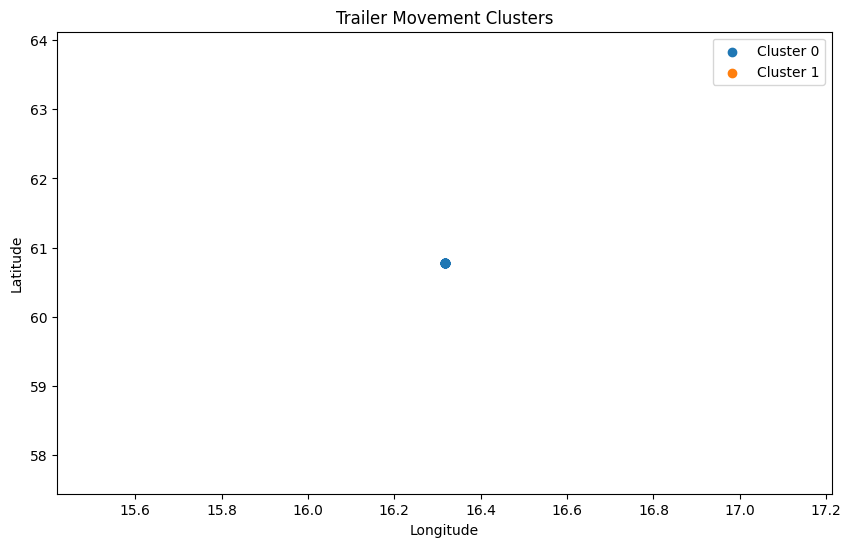

In [13]:
# Scatter plot with different colors for each cluster
plt.figure(figsize=(10, 6))
for cluster_num in range(num_clusters):
    cluster_data = data_combined[data_combined['Cluster'] == cluster_num]
    plt.scatter(cluster_data['FilteredLongitude'], cluster_data['FilteredLatitude'], label=f'Cluster {cluster_num}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trailer Movement Clusters')
plt.legend()
plt.show()


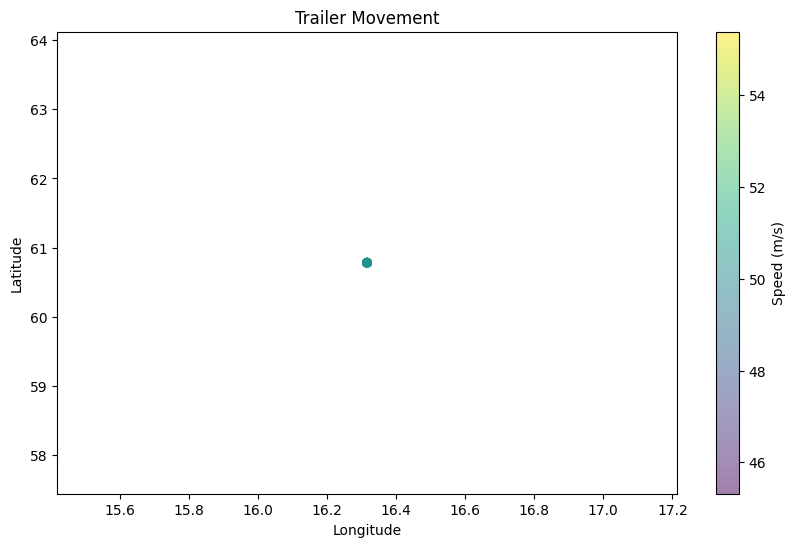

In [14]:
# Plot GPS coordinates over time
plt.figure(figsize=(10, 6))
plt.scatter(data_combined['FilteredLongitude'], data_combined['FilteredLatitude'], c=data_combined['Speed'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Speed (m/s)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trailer Movement')
plt.show()


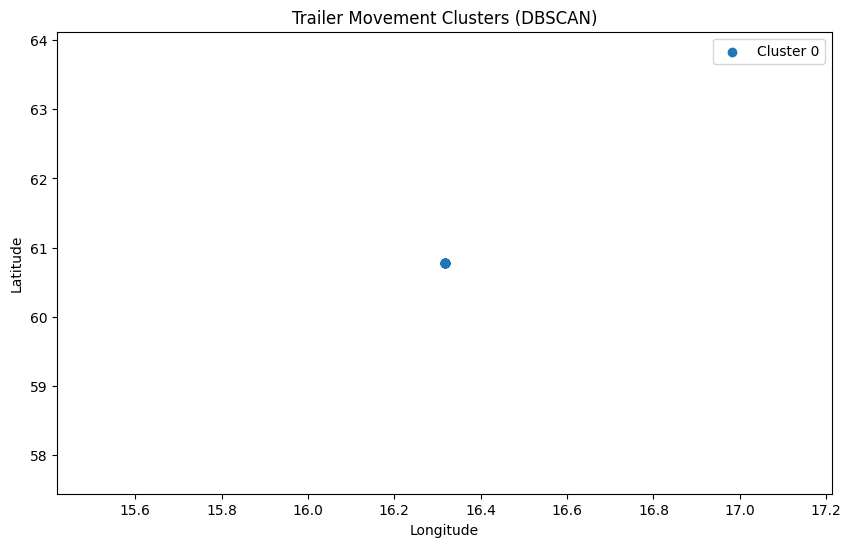

In [12]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=5)
data_combined['DBSCAN_Cluster'] = dbscan.fit_predict(features_for_clustering)

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
for cluster_num in data_combined['DBSCAN_Cluster'].unique():
    if cluster_num == -1:
        continue  # Skip noise points
    cluster_data = data_combined[data_combined['DBSCAN_Cluster'] == cluster_num]
    plt.scatter(cluster_data['FilteredLongitude'], cluster_data['FilteredLatitude'], label=f'Cluster {cluster_num}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trailer Movement Clusters (DBSCAN)')
plt.legend()
plt.show()


In [ ]:
# Note: I am not sure whether the data handling was not as per the standards. But considering the results I have received
# it can be interpreted that
# 1. The trailer was in uniform motion.
# 2. The trailer was relocated using a single transportation mode; train or road. 
